### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Cai Y et al 2022_

- **Developed by**: Carlos Talavera-López PhD
- **Computational Health Centre - Helmholtz Munich**
- v221015

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.7.0
hypergeom_ufunc             NA
ipykernel                   6.9.1
jedi                        0.18.1
joblib                      1.2.0
kiwisolver                  1.4.4
llvmlite                    0.39.1
matplotlib                  3.6.1
mpl_toolkits                NA
natsort                     8.2.0
nbinom_ufunc                NA
ncf_ufunc                   NA
numba                       0.56.2
numpy                       1.23.3
packaging           

### Read datasets

In [3]:
adata = sc.read_h5ad('/home/cartalop/data/single_cell/lung/tb/caiy2022/CaiY2022_TB.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 223089 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol'
    var: 'gene_name'

In [4]:
adata.obs['donor'].value_counts()

P3    93079
P1    37811
P4    34720
P2    26189
P5    20644
P6    10646
Name: donor, dtype: int64

In [5]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 223089 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol'
    var: 'gene_name'

### Filter cells with less than 200 genes

In [6]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

filtered out 150854 cells that have less than 200 genes expressed
72235 61533


In [7]:
sample_object.shape

(72235, 61533)

In [8]:
sample_object.var

,gene_name
gene_id,
ENSG00000223972.5,DDX11L1
ENSG00000227232.5,WASH7P
ENSG00000278267.1,MIR6859-1
ENSG00000243485.5,MIR1302-2HG
ENSG00000284332.1,MIR1302-2
...,...
ENSG00000198695.2,MT-ND6
ENSG00000210194.1,MT-TE
ENSG00000198727.2,MT-CYB


### Replace gene symbols 

In [9]:
sample_object.var['gene_id'] = sample_object.var.index.copy()
sample_object.var.set_index('gene_name', inplace = True)
sample_object.var.head()

,gene_id
gene_name,
DDX11L1,ENSG00000223972.5
WASH7P,ENSG00000227232.5
MIR6859-1,ENSG00000278267.1
MIR1302-2HG,ENSG00000243485.5
MIR1302-2,ENSG00000284332.1


In [10]:
sample_object.var_names = [str(i) for i in sample_object.var_names]
sample_object.var_names_make_unique()


/home/cartalop/mambaforge/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


### Compute QC stats

In [11]:
sample_object.shape

(72235, 61533)

In [12]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

,gene_id,mt,ribo
DDX11L1,ENSG00000223972.5,False,False
WASH7P,ENSG00000227232.5,False,False
MIR6859-1,ENSG00000278267.1,False,False
MIR1302-2HG,ENSG00000243485.5,False,False
MIR1302-2,ENSG00000284332.1,False,False
...,...,...,...
MT-ND6,ENSG00000198695.2,True,False
MT-TE,ENSG00000210194.1,True,False
MT-CYB,ENSG00000198727.2,True,False
MT-TT,ENSG00000210195.2,True,False


In [13]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [14]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1

In [15]:
sample_object

AnnData object with n_obs × n_vars = 72235 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC metrics

In [16]:
sample_object.var_names

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'OR4G4P', 'OR4G11P', 'OR4F5', 'ENSG00000238009',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=61533)

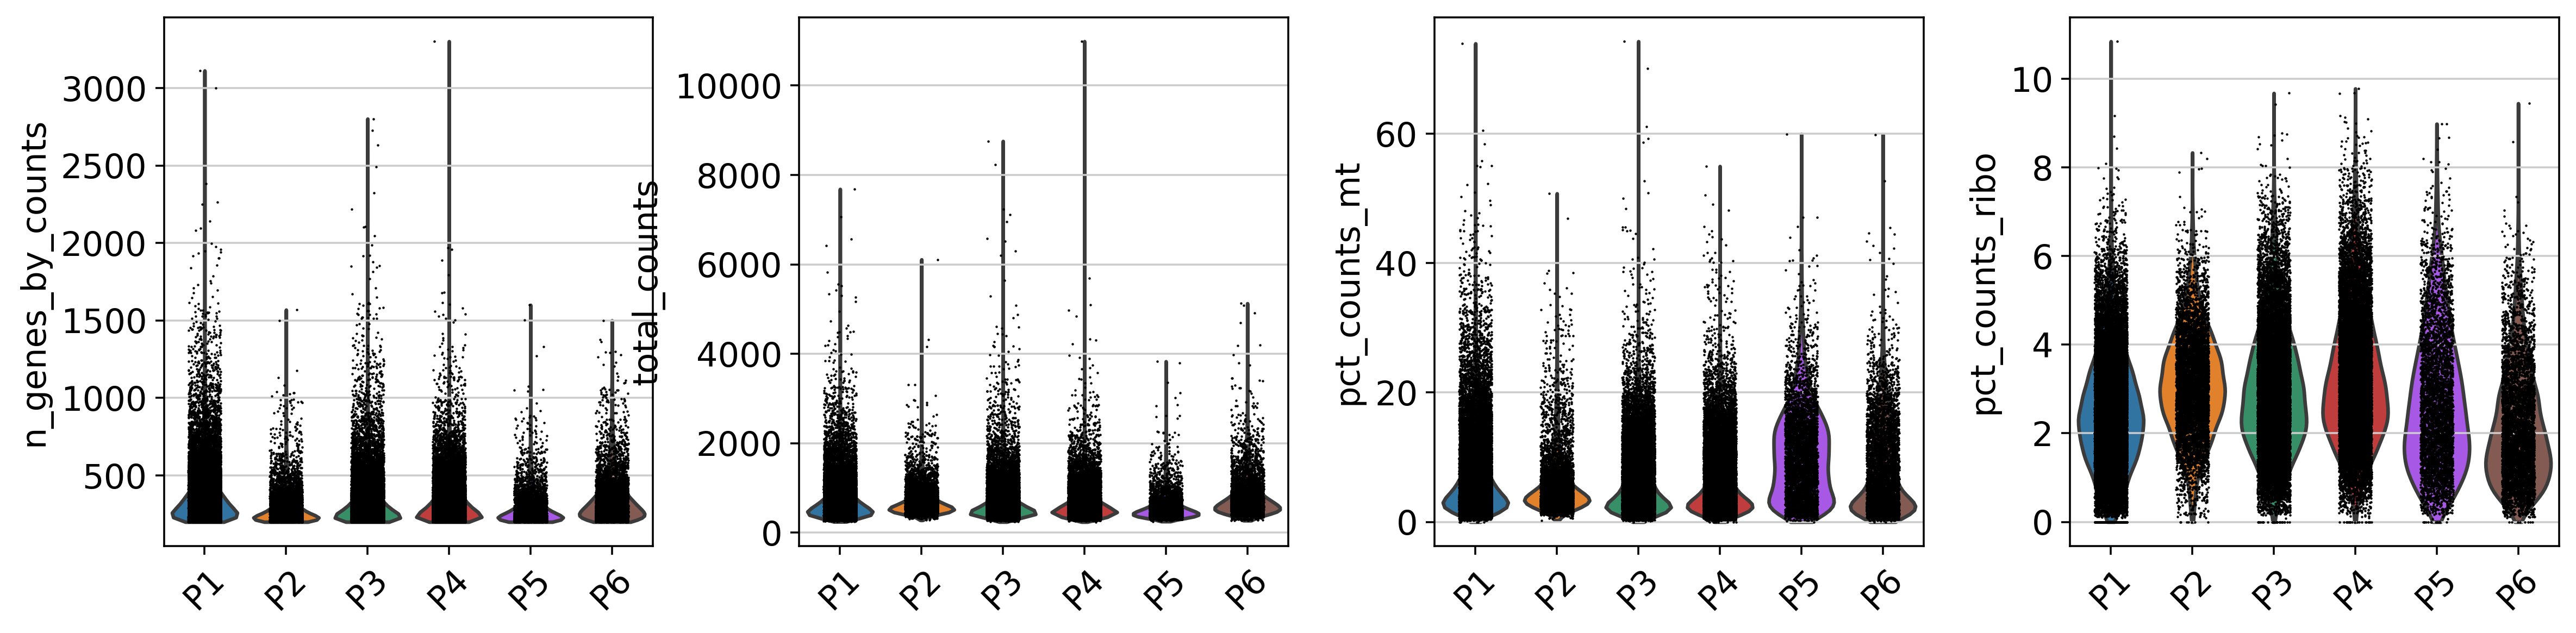

In [17]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

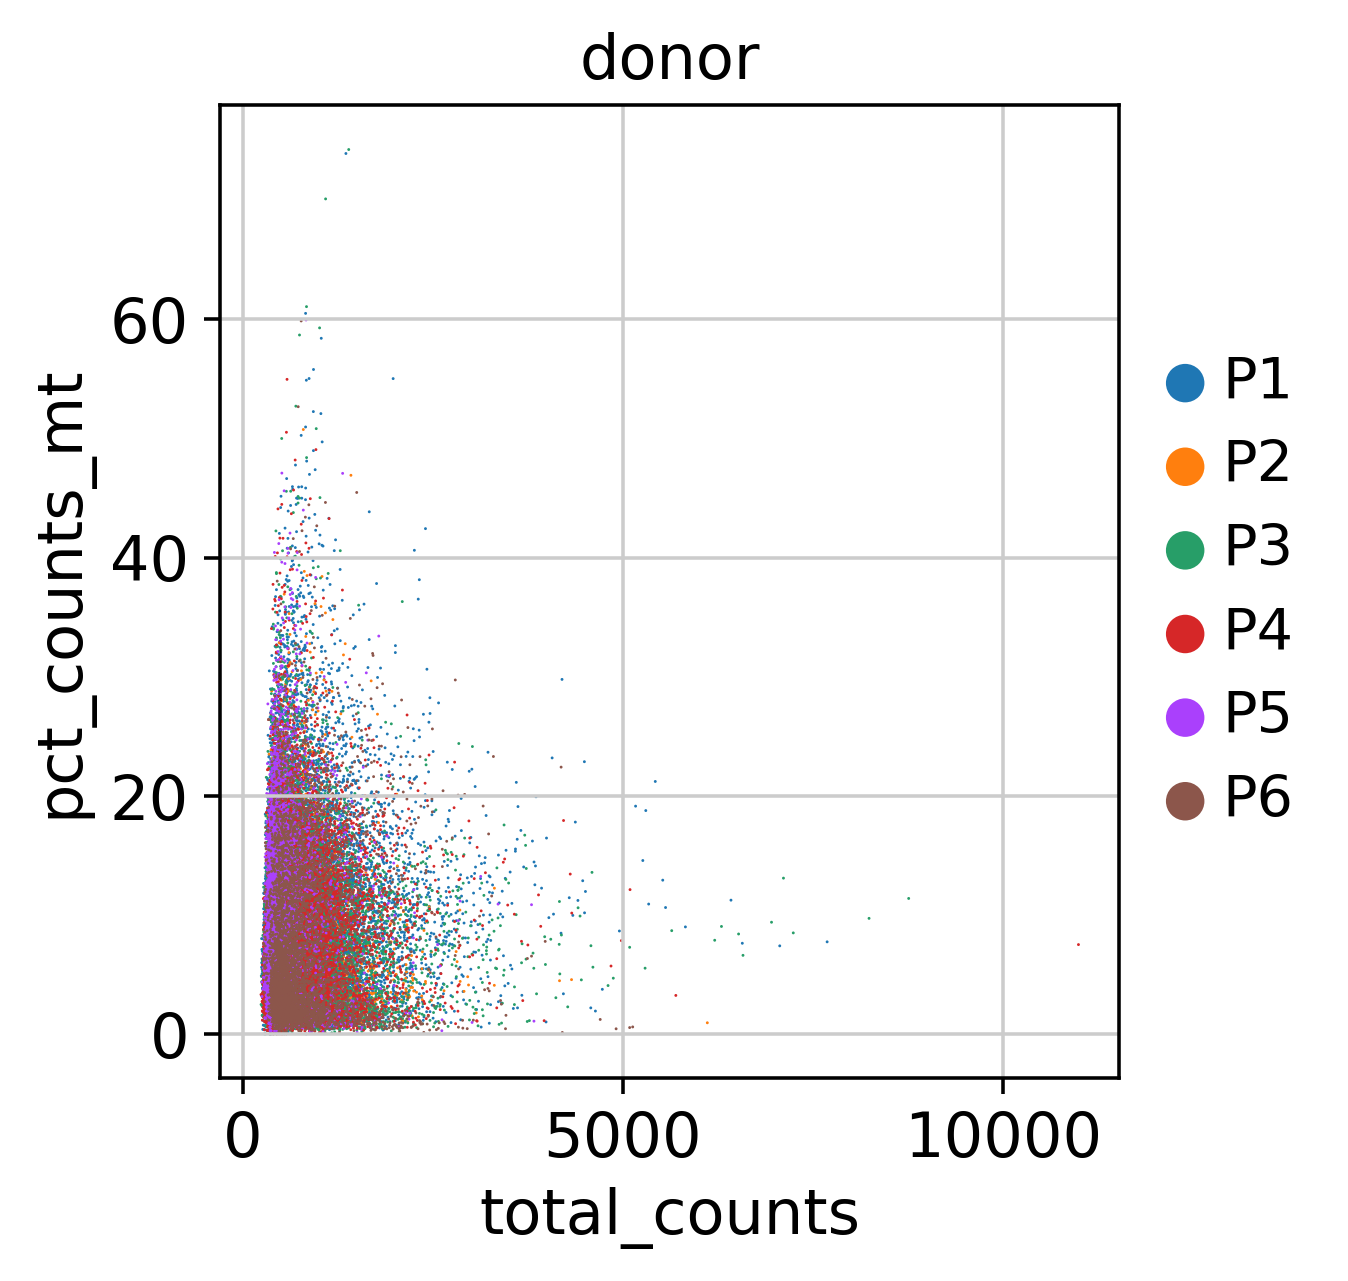

In [18]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "donor")

### Add sample sex covariate

In [19]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [20]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
MT-TF,ENSG00000210049,577,647,MT
MT-RNR1,ENSG00000211459,648,1601,MT
MT-TV,ENSG00000210077,1602,1670,MT
MT-RNR2,ENSG00000210082,1671,3229,MT
MT-TL1,ENSG00000209082,3230,3304,MT


In [21]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Y_RNA', 'SNORA70', 'XGY2', 'RNU6-1334P', 'SRY', 'RNASEH2CP1',
       'TOMM22P2', 'RPS4Y1', 'HSFY3P', 'NAP1L1P2',
       ...
       'PPP1R12BP1', 'RNU6-1314P', 'CYCSP48', 'ANKRD36P1', 'TPTE2P4',
       'CYCSP49', 'SLC25A15P1', 'PARP4P1', 'CCNQP2', 'CTBP2P1'],
      dtype='object', length=429)

In [22]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

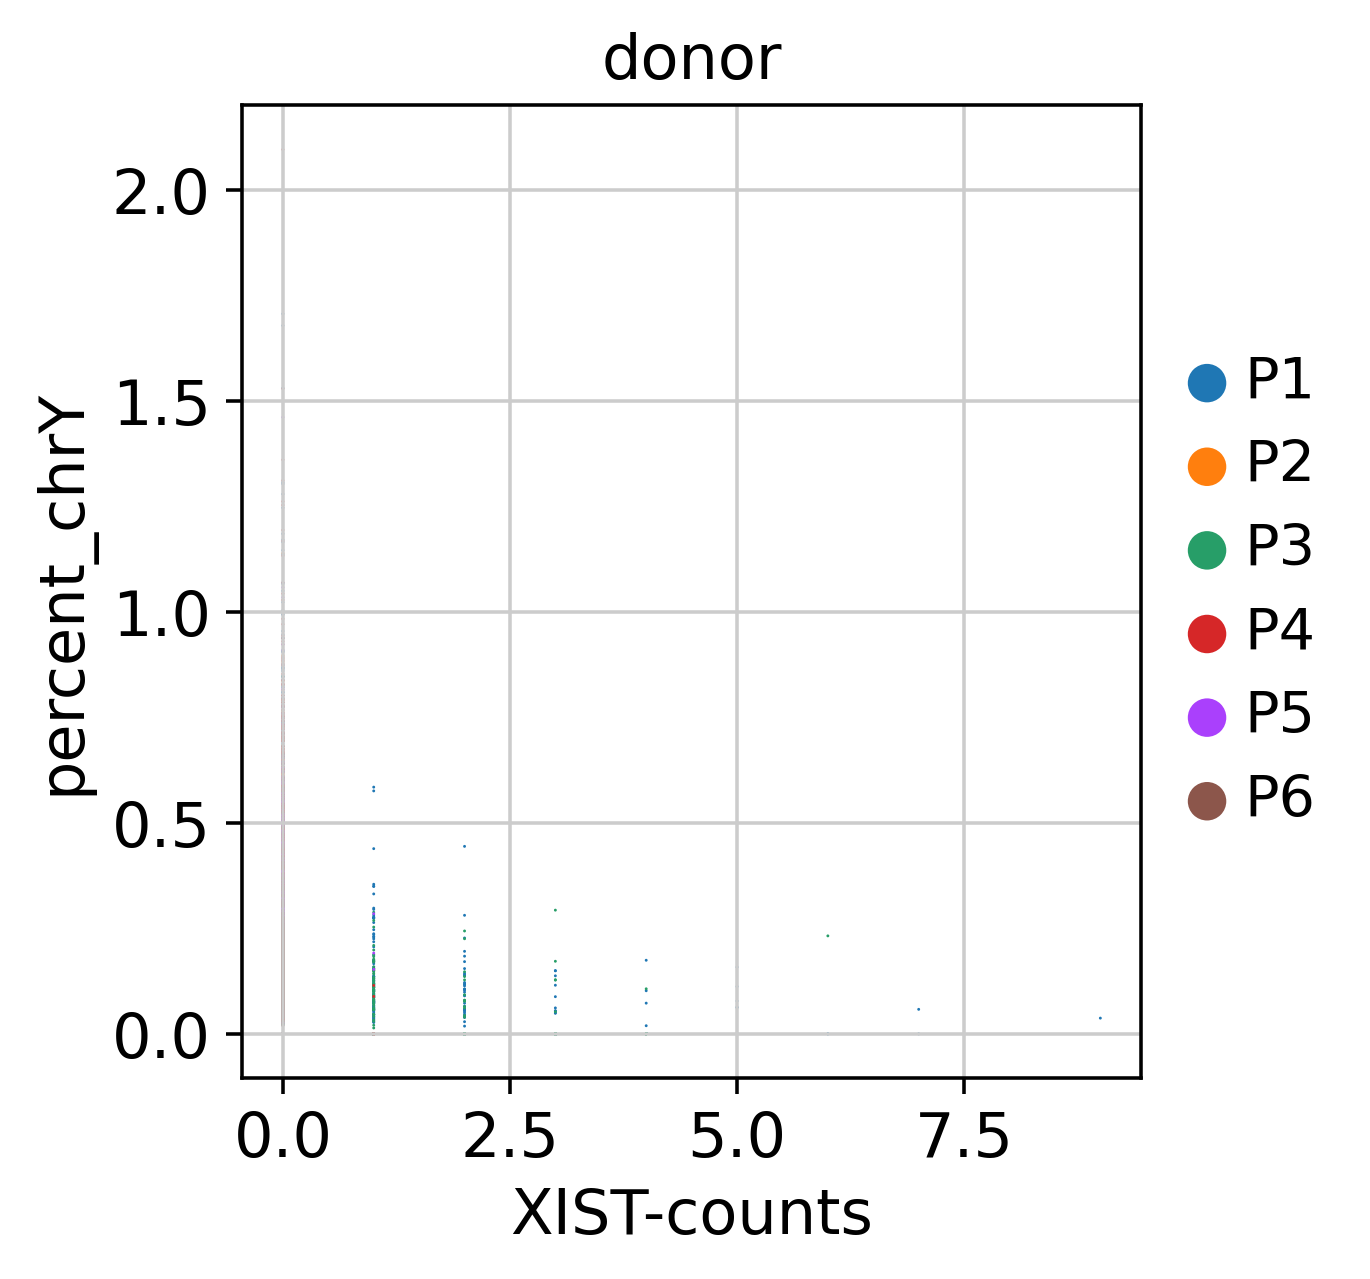

In [23]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "donor")

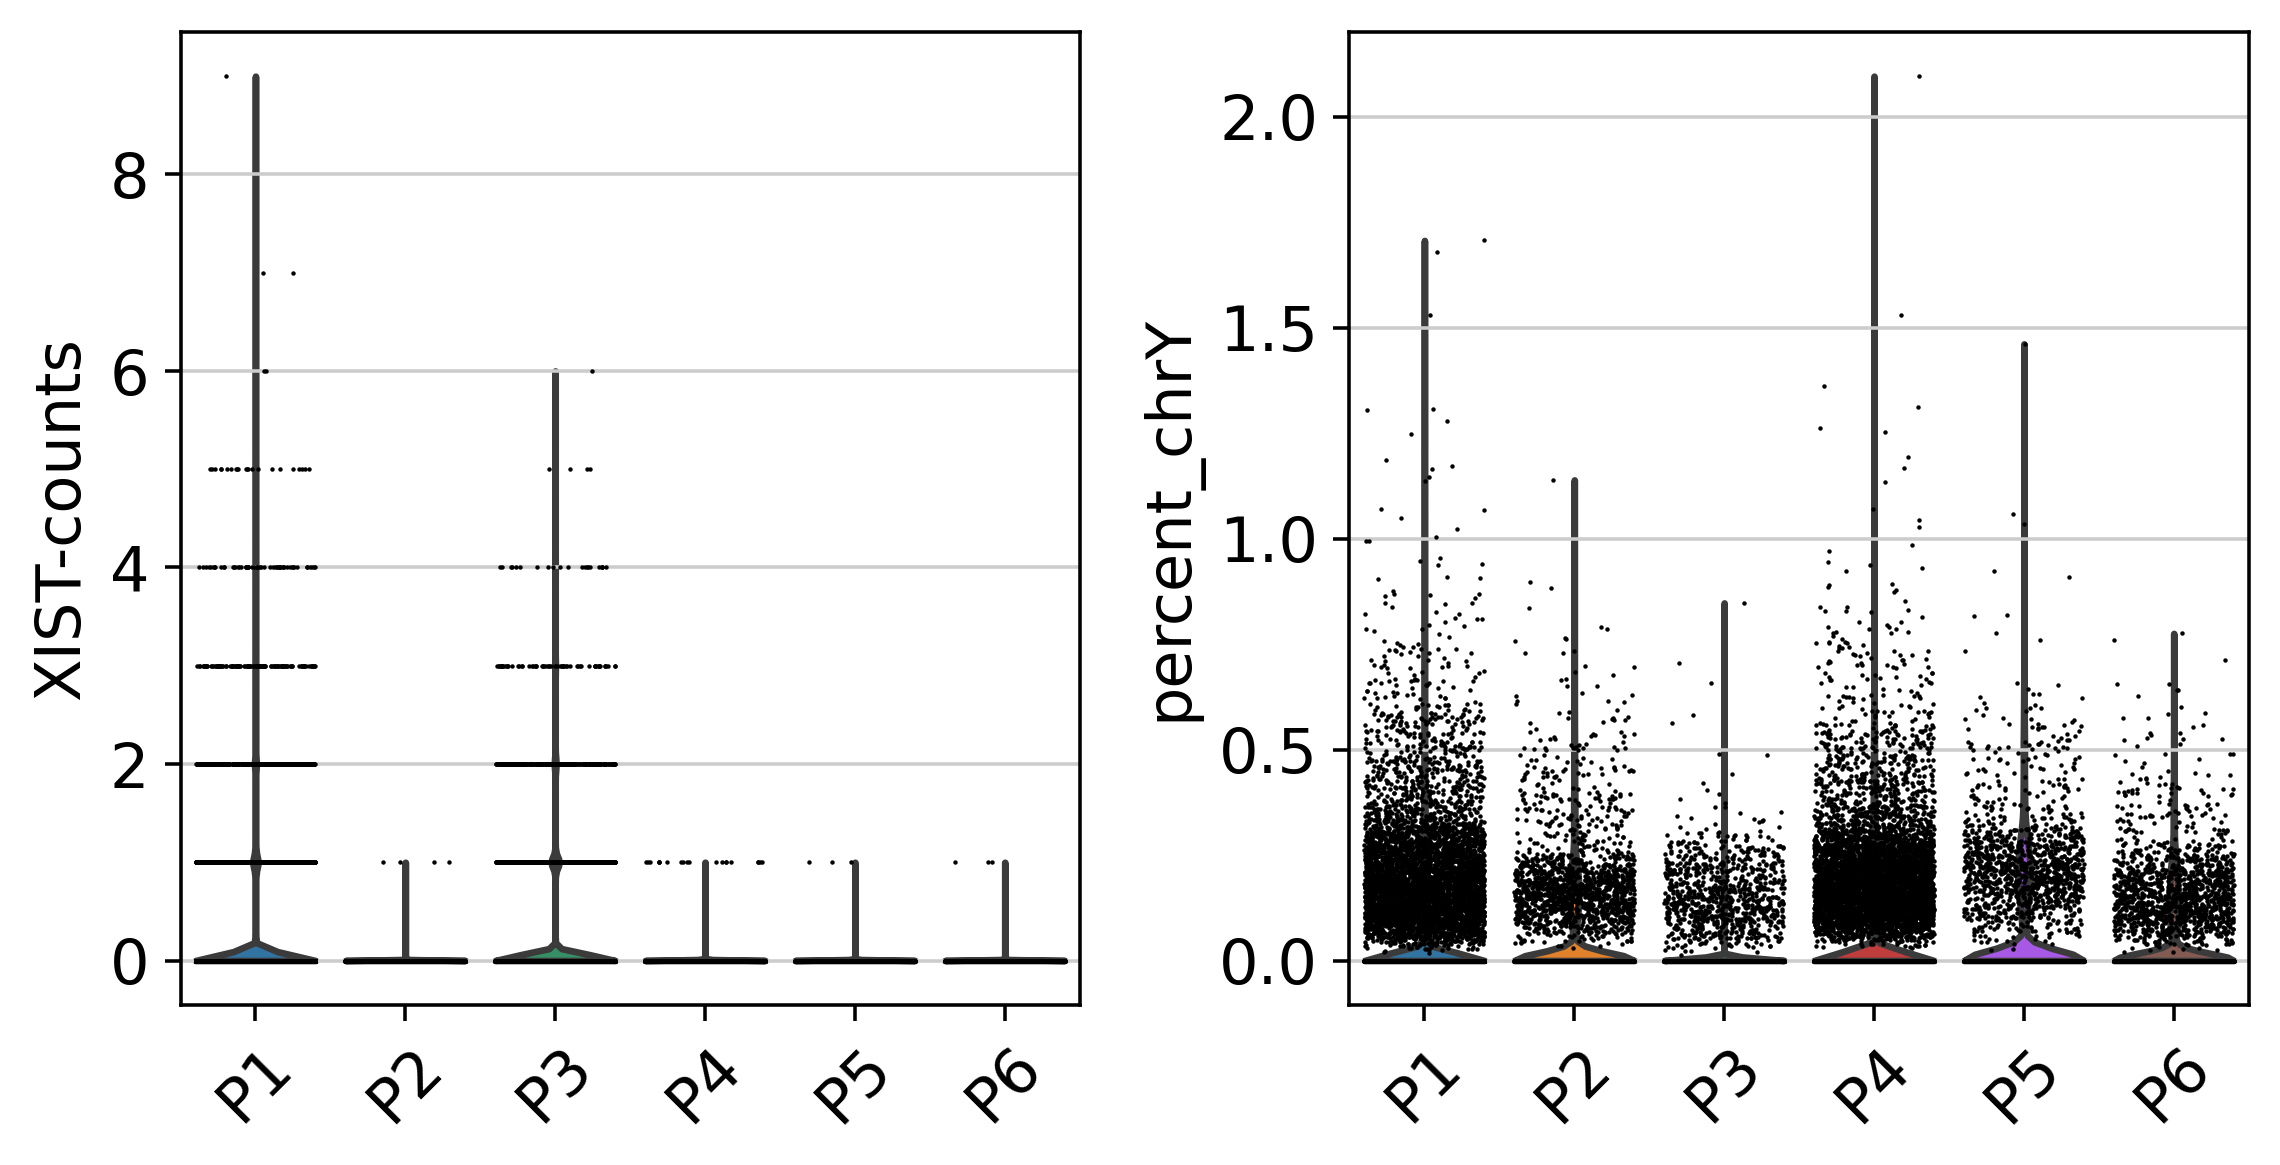

In [24]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'donor', rotation = 45)

### Calculate cell cycle scores

In [25]:
!if [ ! -f /home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt ]; then curl -o /home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [26]:
cell_cycle_genes = [x.strip() for x in open('/home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [27]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ENSG00000288934', 'IGKV4-1', 'IGKV3-11', 'IGKV3-15', 'IGKV3-20', 'ENSG00000286848', 'ENSG00000248223', 'CD74', 'H1-4', 'ENSG00000230521', 'ENSG00000227766', 'TUBB', 'ENSG00000271581', 'ACTB', 'ENSG00000243004', 'TRBV7-2', 'TRBV13', 'ENSG00000288882', 'TRBJ2-7', 'ENSG00000272256', 'PABPC1', 'ENSG00000203396', 'VIM-AS1', 'HBB', 'BEST1', 'AHNAK', 'MALAT1', 'ENSG00000257764', 'BTG1-DT', 'HELLPAR', 'HSP90B1', 'TPT1', 'ENSG00000273149', 'IGHA2', 'IGHG2', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'ENO3', 'ENSG00000266865', 'JSRP1', 'EEF2', 'ENSG00000267598', 'ENSG00000283907', 'BCAS4', 'PRAMENP', 'IGLV1-44', 'IGLV1-40', 'IGLV3-25', 'IGLV3-19', 'MIF-AS1', 'XACT', 'ENSG00000225840', 'MT-RNR1', 'MT-RNR2', 'MT-CO1', 'MT-CO2', 'MT-CYB']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:00)
computing score 'G2M_score'


/home/cartalop/mambaforge/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/home/cartalop/mambaforge/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


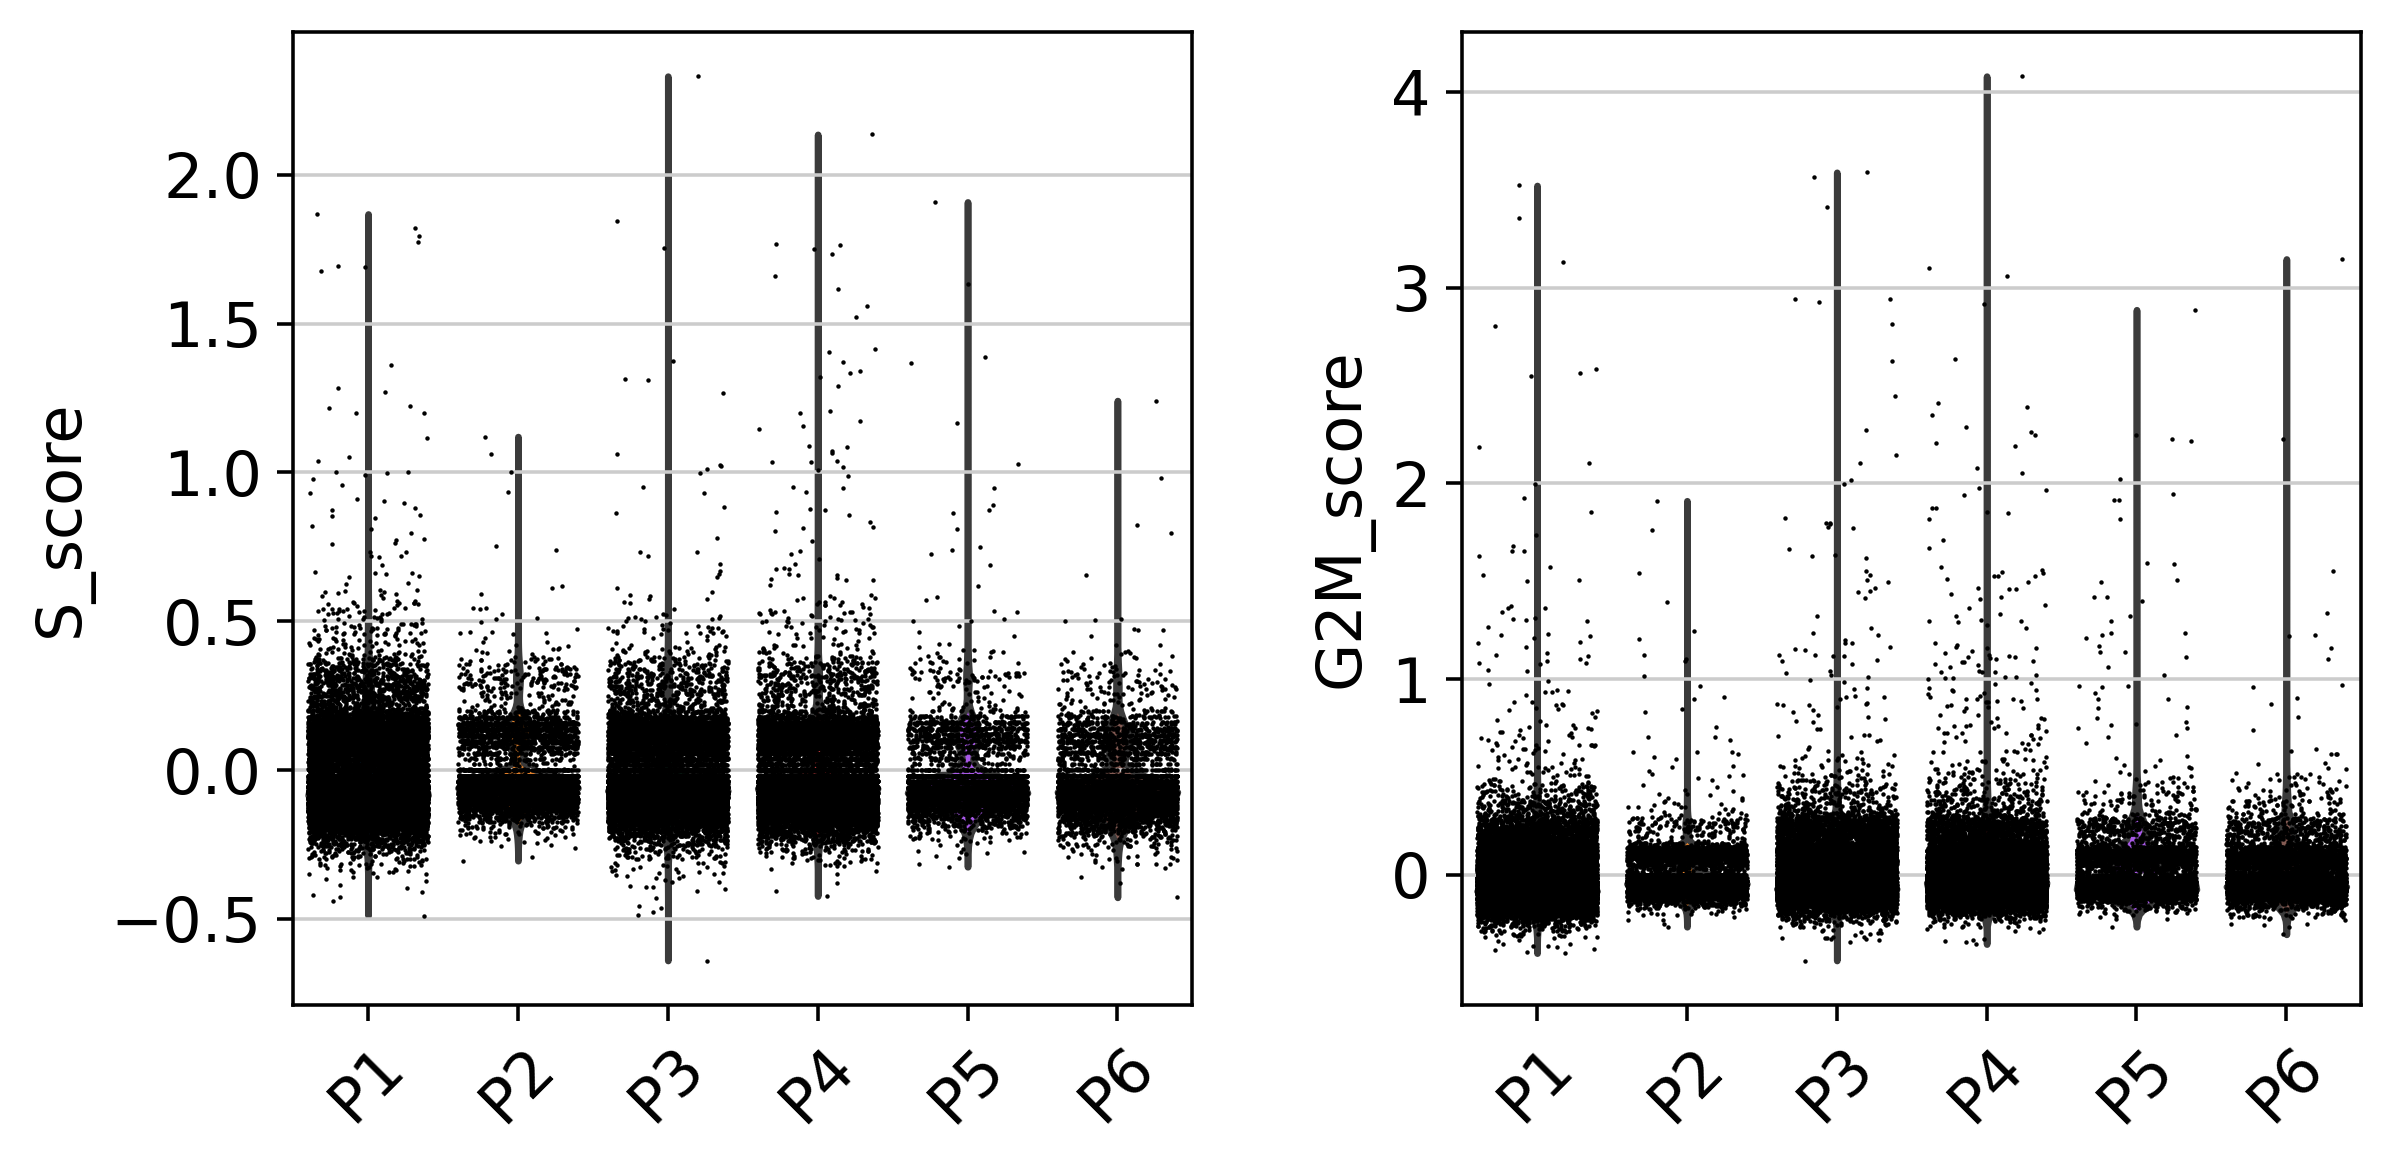

In [28]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'donor', rotation = 45)

In [29]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 72235 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'

### Predict doublets

Preprocessing...


/home/cartalop/mambaforge/lib/python3.9/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/cartalop/mambaforge/lib/python3.9/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 12.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 197.6 seconds


502

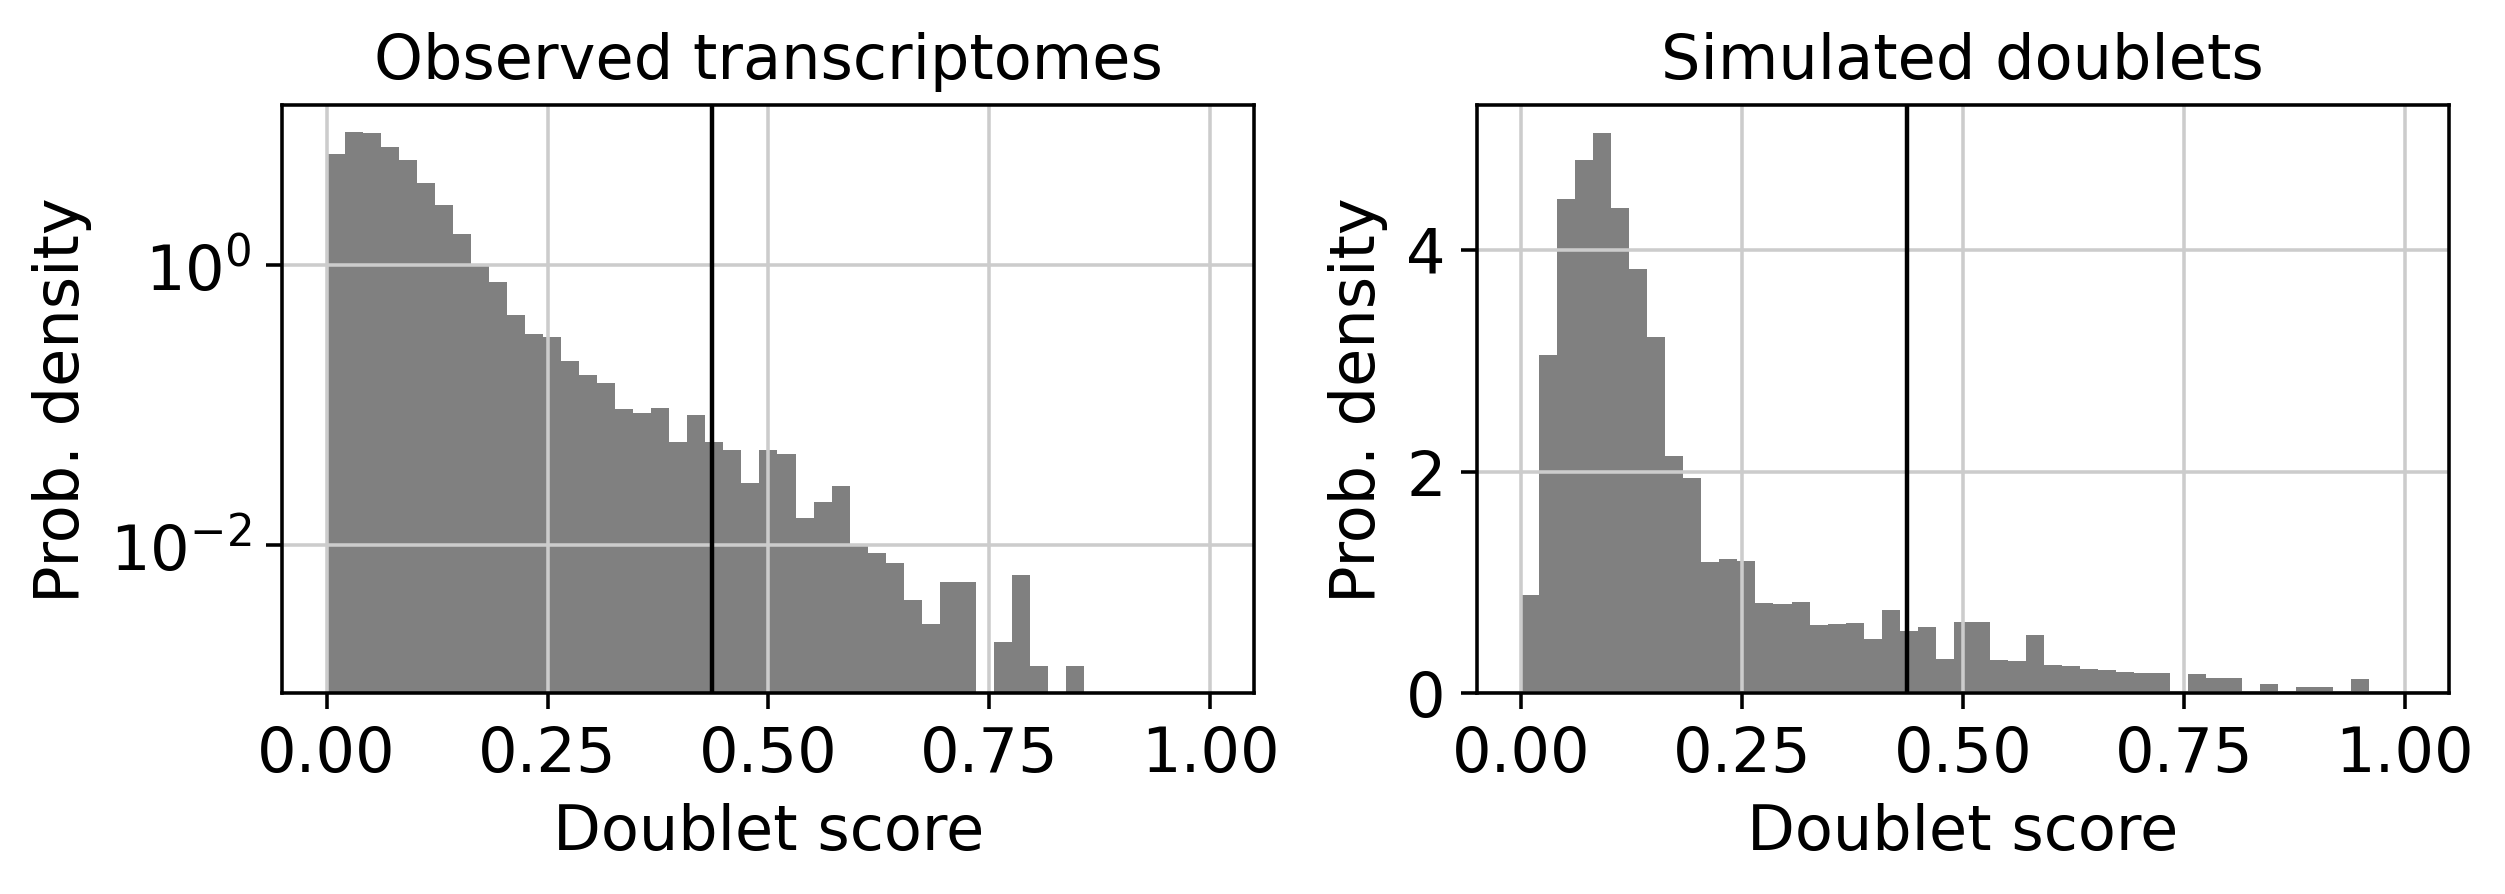

In [30]:
scrub = scr.Scrublet(sample_object.X)
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(sample_object.obs['predicted_doublets'])

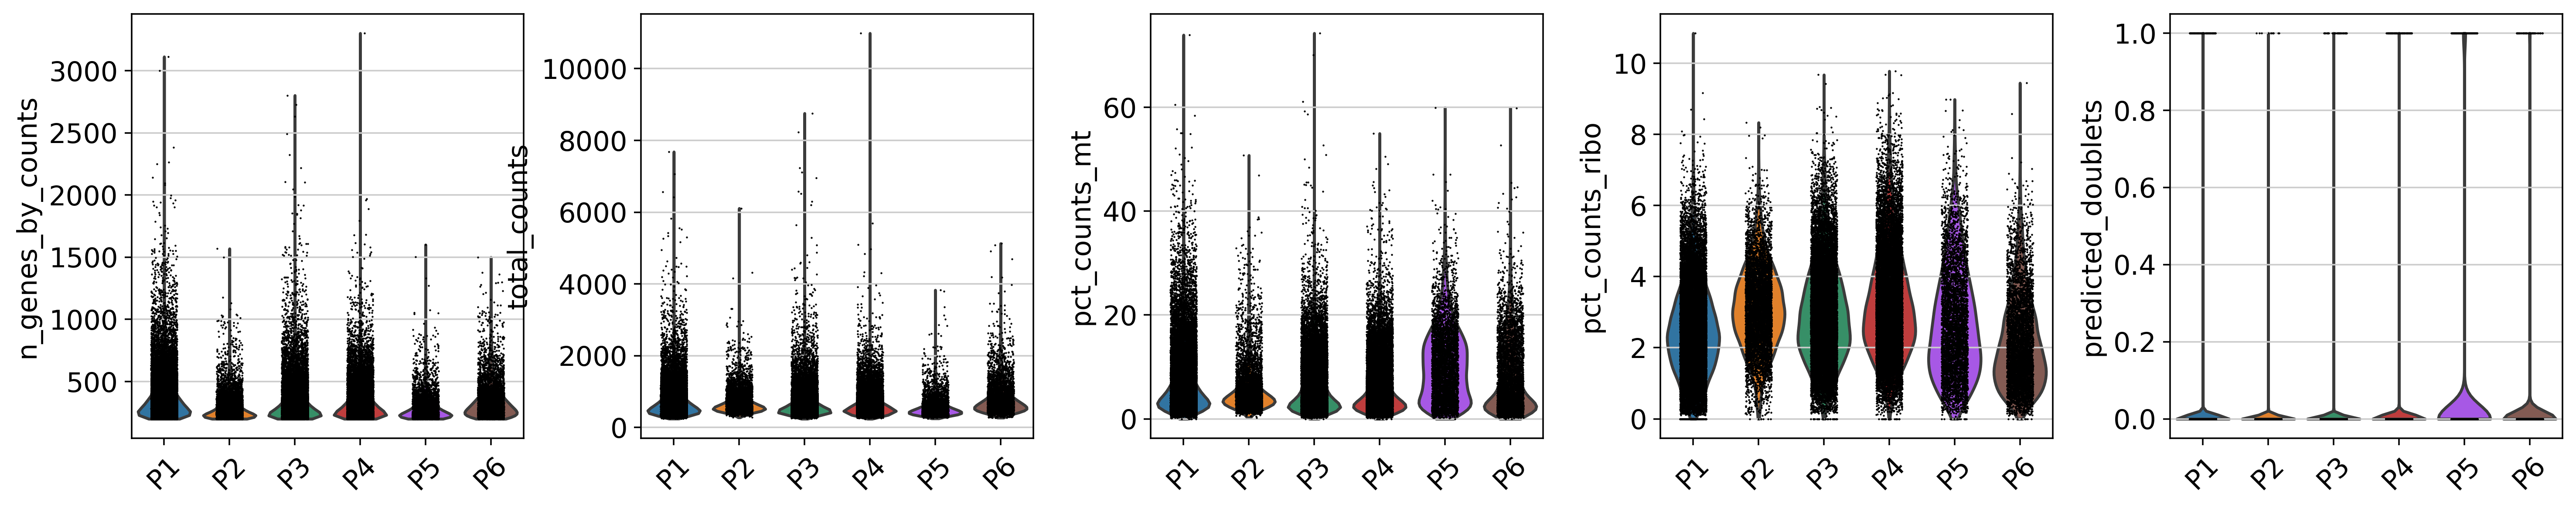

In [31]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

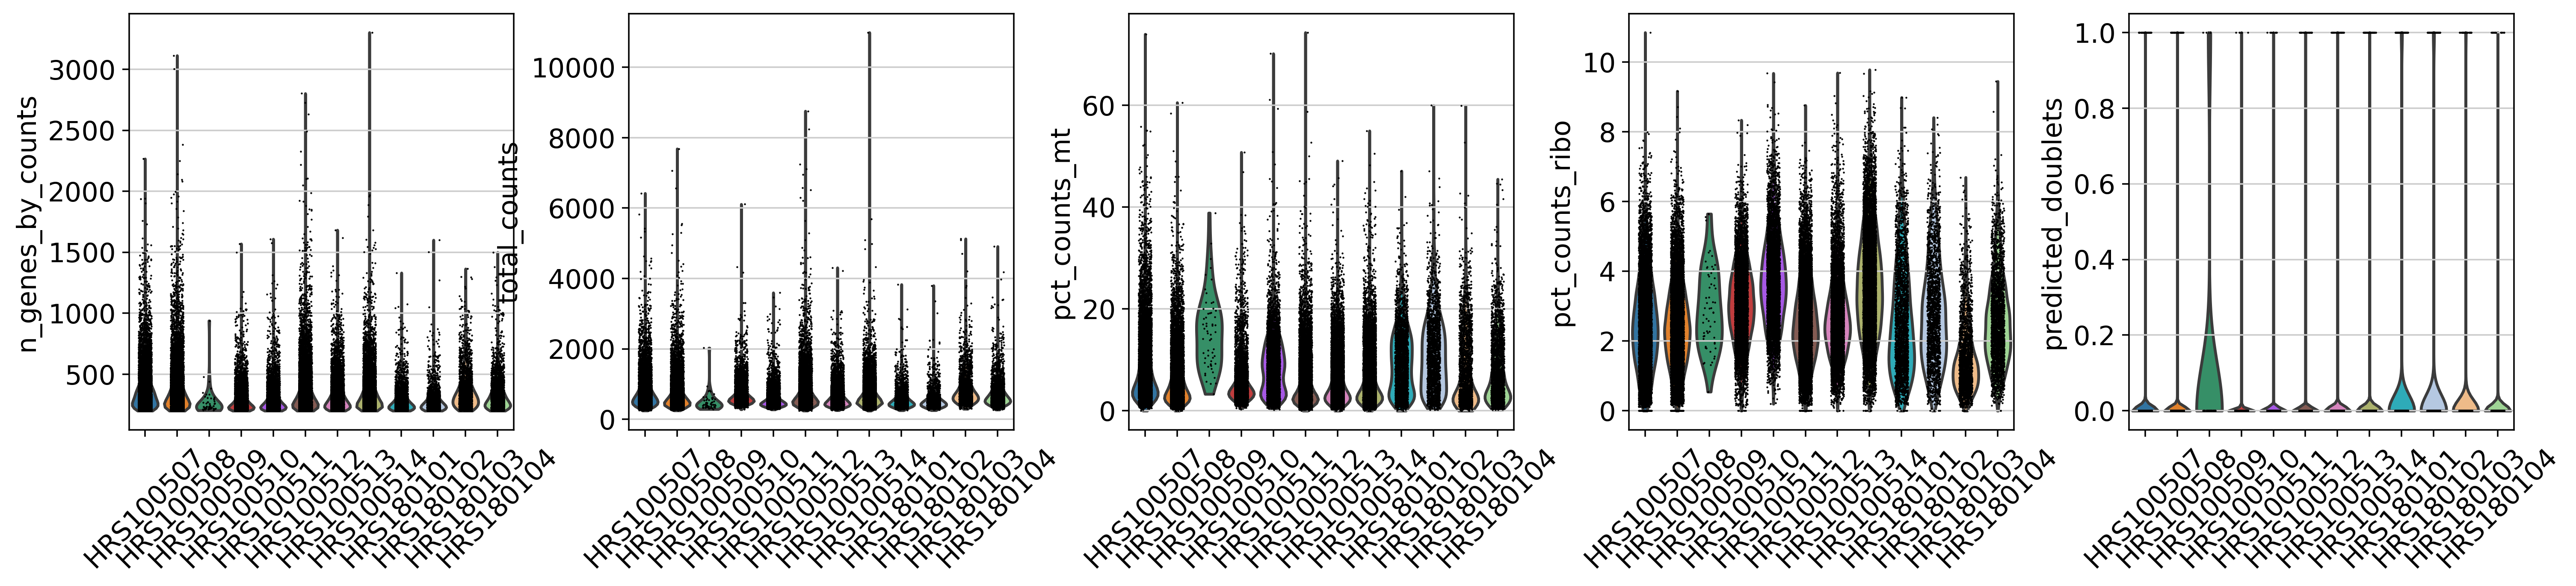

In [32]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [33]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 72235 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Export object

In [35]:
sample_object.write('/home/cartalop/data/single_cell/lung/tb/caiy2022/CaiY2022_TB_QCed_pre-process_ctl221015.h5ad')